# Seminar 01: Naive Bayes from scratch

Today we will write Naive Bayes classifier supporting different feature probabilities.

_Authors: [Radoslav Neychev](https://github.com/neychev), [Vladislav Goncharenko](https://github.com/v-goncharenko)_

## Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [2]:
matplotlib.rcParams['font.size'] = 11

In [3]:
plt.style.use('dark_background')

First to load dataset we're going to use [`sklearn`](https://scikit-learn.org/stable/) package which we will extensively use during the whole course.

`sklearn` implement most of classical and frequently used algorithms in Machine Learning. Also it provides [User Guide](https://scikit-learn.org/stable/user_guide.html) describing principles of every bunch of algorithms implemented.

As an entry point to main `sklearn`'s concepts we recommend [getting started tutorial](https://scikit-learn.org/stable/getting_started.html) (check it out yourself). [Further tutorials](https://scikit-learn.org/stable/tutorial/index.html) can also be handy to develop your skills.

First functionality we use is cosy loading of [common datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). All we need to do is just one function call.

Object generated by [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) is described as:

> Dictionary-like object, the interesting attributes are:
>
> ‘data’, the data to learn,
>
>‘target’, the classification labels,
>
>‘target_names’, the meaning of the labels,
>
>‘feature_names’, the meaning of the features,
>
>‘DESCR’, the full description of the dataset,
>
>‘filename’, the physical location of iris csv dataset (added in version 0.20)

Let's see what we have

In [4]:
dataset = datasets.load_iris()

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

If you aren't familiar with Iris dataset - take a minute to read description above =) (as always [more info about it in Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set))

__TL;DR__ 150 objects equally distributed over 3 classes each described with 4 continuous features

Just pretty table to look at:

In [5]:
# for now you don't need to understand what happens in this code - just look at the table
ext_target = dataset.target[:, None]
# ext_target = np.expand_dims(dataset.target, axis=-1)
df = pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


Now give distinct names to the data we will use

In [6]:
features = dataset.data
target = dataset.target

features.shape, target.shape

((150, 4), (150,))

__Please, remember!!!__

Anywhere in our course we have an agreement to shape design matrix (named `features` in code above) as 

`(#number_of_items, #number_of_features)`

## Visualize dataset

Our dataset has 4 dimensions however humans are more common to 3 or even 2 dimensional data, so let's plot first 3 features colored with labels values

In [ ]:
# projection 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = Axes3D(fig)

ax.scatter(features[:, 0], features[:, 1], features[:, 3], c=target, marker='o')
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])

plt.show()

In [ ]:
# 3d plot
import plotly.express as px

fig = plt.figure(figsize=(8, 8))
fig = px.scatter_3d(df, x='sepal length (cm)', y='sepal width (cm)', z='petal width (cm)',
                    color='target name')
fig.show()

Then have a look on feature distributions

In [ ]:
# remember this way to make subplots! It could be useful for you later in your work

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, axis in enumerate(axes.flat):
    axis.hist(features[:, i])
    axis.set_xlabel(dataset.feature_names[i])
    axis.set_ylabel('number of objects')

Note that every plot above have own scale

## Classifier implementation

Since we aiming to implement Naive Bayes algorithm first we need some prior distribution defined.

The most common distribution is (of course) Gaussian and it's params are mean and standard deviation. Let's implement class taking list of feature values, estimating distribution params and able to give probability density of any given feature value.

Denote the normal distribution $\mathcal{N}(\mu, \sigma^2)$ PDF:
$$
f(x|\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2})
$$
Let's implement the `GaussianDistribution` class. (Of course in practice one could always use something like `scipy.stats.norm`).

Please note, that making computations with log probabilities is more stable.

In [16]:
class GaussianDistribution:
    def __init__(self, feature):
        '''
        Args:
            feature: column of design matrix, represents all available values
                of feature to model.
                axis=0 stays for samples.
        '''
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)

    def logpdf(self, value):
        '''Logarithm of probability density at value'''
        return  - 0.5 * np.log(2 * np.pi * self.std**2) - ((value - self.mean)**2) / (2 * self.std**2)
    
    def pdf(self, value):
        return  np.exp(self.logpdf(value))

Let's check the result:

In [ ]:
import scipy
_test = scipy.stats.norm(loc=features[:, :2].mean(axis=0), scale=features[:, :2].std(axis=0))
assert np.allclose(
    GaussianDistribution(features[:, :2]).logpdf(features[:5, :2]),
    _test.logpdf(features[:5, :2])
)
print('Seems fine!')

In [17]:
GaussianDistribution(features[:, 2]).pdf(features[:5, 2])

array([0.09236407, 0.09236407, 0.0854514 , 0.09951395, 0.09236407])

### [Probabilistic model](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Probabilistic_model)

Let's focus on the classification problem now. For the case of $K$ classes label $y_i \in \{C_1, \ldots, C_k\}$. Iris classification problem has 3 classes, so $K=3$. Bayes' Theorem takes the following form:

$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$

Please note, we prefer working with log probabilities here as well. So the equation above will take the following form:
$$
\log P(y_i = C_k|\mathbf{x}_i) = \log P(\mathbf{x}_i|y_i = C_k) + \log P(y_i = C_k) - \log P(\mathbf{x}_i)
$$

As one could mention, to find the class label with the highest probability we even do not need the last term $P(\mathbf{x}_i)$. However, we need it to get the correct estimation of the probability $P(y_i = C_k|\mathbf{x}_i)$. 

The $P(\mathbf{x}_i)$ term can be computed using the following property:
$$
P(\mathbf{x}_i) = \sum_{k=1}^K P(y_i = C_k)  P(\mathbf{x}_i|y_i=C_k).
$$
It can be computed from $\log P(\mathbf{x}_i|y_i=C_k)$ values using `logsumexp` function located in `scipy.special`.

Now let's implement the Naive Bayes classifier itself. The class below is inherited from `sklearn` base classes and provides all the main methods.

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp


class NaiveBayes(BaseEstimator, ClassifierMixin):
    '''
    Please note, using `X` and `y` for design matrix and labels in general is not a good choice,
    better stick to more informative naming conventions.
    However, to make the code consistent with sklearn implementation, we use `X` and `y` variables here.
    # '''
    def fit(self, X, y, sample_weight=None, distributions=None):
        '''
        sample_weight 
            The argument is ignored. For comatibility only.
        '''
        assert sample_weight is None
        self.unique_labels = np.unique(y)
        
        # If distributions of features are not specified, they a treated Gaussian
        if distributions is None:
            distributions = [GaussianDistribution] * X.shape[1]
        else:
            # Check whether distributions are passed for all features
            assert len(distributions) == X.shape[1]        

        # Here we find distribution parameters for every feature in every class subset
        # so P(x^i|y=C_k) will be estimated only using information from i-th feature of C_k class values
        self.conditional_feature_distributions = {} # label: [distibution for feature 1, ...]
        for label in self.unique_labels:
            feature_distribution = []
            for column_index in range(X.shape[1]):
                # `column_index` feature values for objects from `label` class
                feature_column = X[y == label, column_index]
                fitted_distr = distributions[column_index](feature_column)
                feature_distribution.append(fitted_distr)
            self.conditional_feature_distributions[label] = feature_distribution

        # Prior label distributions (unconditional probability of each class)
        self.prior_label_distibution = {
            label: sum((y==label).astype(float))/len(y)
            for label in self.unique_labels
        }

    
    def predict_log_proba(self, X):
        # Matrix of shape (n_objects : n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        
        # Here we compute the class log probabilities for each class sequentially b
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(X.shape[1]):
                # All loglikelihood for every feature w.r.t. fixed label

                class_log_probas[:, label_idx] += self.conditional_feature_distributions[label][idx].logpdf(X[:, idx])

            # Add log proba of label prior
            class_log_probas[:, label_idx] += np.log(self.prior_label_distibution[label])

        for idx in range(X.shape[1]):
        # If you want to get probabilities, you need to substract the log proba for every feature
            class_log_probas -= logsumexp(class_log_probas, axis=1)[:, None]
        return class_log_probas
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        # we need to cast labels to their original form (they may start from number other than 0)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

In [26]:
nb = NaiveBayes()
nb.fit(features, target)
print('log probas:\n{}'.format(nb.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb.predict(features[:2])))
print('\nIt`s alive! More tests coming.')

log probas:
[[  0.         -41.14063634 -57.90531295]
 [  0.         -38.72865982 -56.71097942]]
predicted labels:
[0 0]

It`s alive! More tests coming.


Now let's check our Naive Bayes classifier on the unseed data. To do so we will use `train_test_split` from `sklearn`.

In [27]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=24)

print(features_train.shape, features_test.shape)

(112, 4) (38, 4)


In [28]:
nb = NaiveBayes()
nb.fit(features_train, target_train, distributions=[GaussianDistribution]*4)
nb_test_log_proba = nb.predict_log_proba(features_test)

In [29]:
print('Naive Bayes classifier accuracy on the train set: {}'.format(nb.score(features_train, target_train)))

Naive Bayes classifier accuracy on the train set: 0.9642857142857143


In [30]:
print('Naive Bayes classifier accuracy on the test set: {}'.format(nb.score(features_test, target_test)))

Naive Bayes classifier accuracy on the test set: 0.9473684210526315


Finally, let's comapre the Naive Bayes classifier with the `sklearn` implementations.

In [31]:
from sklearn import naive_bayes

sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(features_train, target_train)
sklearn_nb_test_log_proba = sklearn_nb.predict_log_proba(features_test)

In [32]:
print('sklearn implementation accuracy on the train set: {}'.format(sklearn_nb.score(features_train, target_train)))

sklearn implementation accuracy on the train set: 0.9642857142857143


In [33]:
print('sklearn implementation accuracy on the test set: {}'.format(sklearn_nb.score(features_test, target_test)))

sklearn implementation accuracy on the test set: 0.9473684210526315


And let's even check the predictions. If you used Gaussian distribution and done everything correctly, the log probabilities should be the same.

In [ ]:
assert np.allclose(nb_test_log_proba, sklearn_nb_test_log_proba), 'log probabilities do not match'
print('Seems alright!')

#### Comparing to kNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
knn = KNeighborsClassifier(n_neighbors=3)

In [36]:
knn.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=3)

In [37]:
knn.score(features_train, target_train)

0.9642857142857143

In [38]:
knn.score(features_test, target_test)

0.9736842105263158

Seem like Naive Bayes classifier performance is comparable to the kNN, while Naive Bayes does not need to store all the train data (while kNN need).

## Advanced distribution for NaiveBayes

Let's take a look at violin plots for every feature in our dataset:

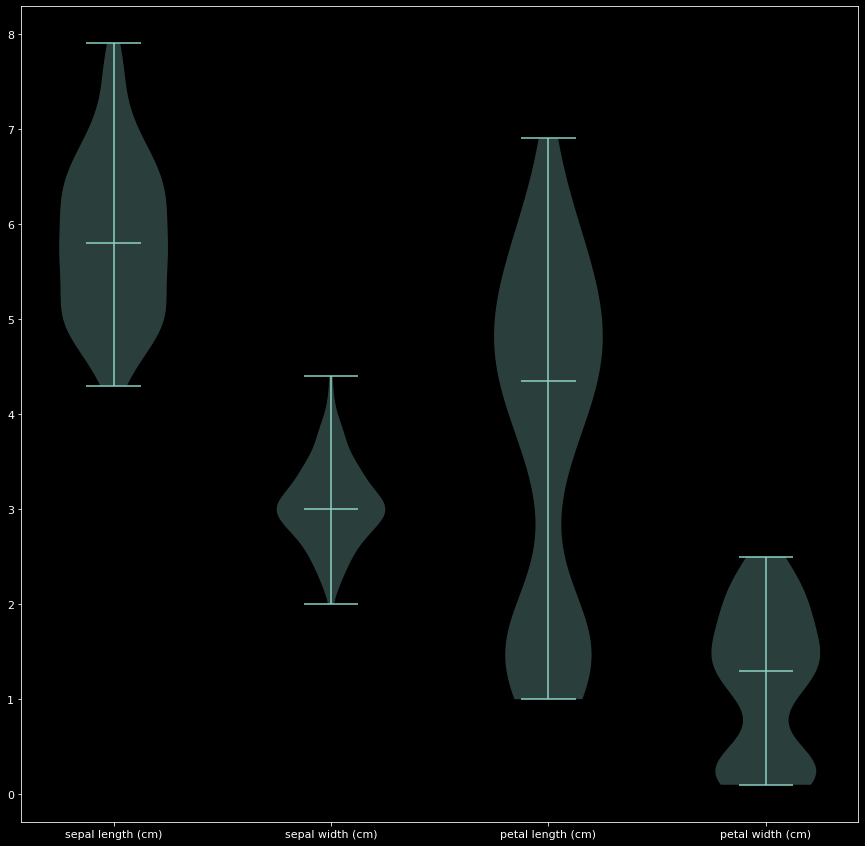

In [39]:
labels = df.columns[:4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), sharey=True)
plt.violinplot(features, showmedians=True)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)
plt.show()

Although we do love Gaussian distribution it is still unimodal while our features are substantially multimodal (see histograms above). So we have to implement more robust distribution estimator - Kernel Density Estimator (KDE).

Idea for this method is simple: we assign some probability density to a region around actual observation. (We will return to density estimation methods to describe them carefully later in this course).

Fortunately `sklearn` have KDE implemented for us already. All it needs is vector of feature values.

To get probability estimations using KDE one can easily access the `sklearn.neighbors` module.

Text(0, 0.5, 'probability')

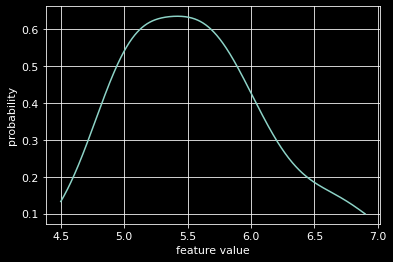

In [40]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.28, kernel='gaussian')
feature_col = features[target==2, 2]
kde.fit(feature_col.reshape((-1, 1)))
linspace = np.linspace(feature_col.min(), feature_col.max(), 1000)
plt.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
plt.grid()
plt.xlabel('feature value')
plt.ylabel('probability')

To make it compatible with the Naive Bayes classifier we have implemented above, we need to create class with the same methods:

In [41]:
class GaussianKDE:
    def __init__(self, feature):
        self.kde = KernelDensity(bandwidth=1.)
        self.kde.fit(feature.reshape((-1, 1)))

    def logpdf(self, value):
        return self.kde.score_samples(value.reshape((-1, 1)))

    def pdf(self, value):
        return np.exp(self.log_proba(value))

In [42]:
nb_kde = NaiveBayes()
nb_kde.fit(features, target, distributions=[GaussianKDE]*4)
print('log probas:\n{}'.format(nb_kde.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb_kde.predict(features[:2])))
print('\nIt`s alive!')

log probas:
[[-0.01065833 -4.55225418 -9.74947306]
 [-0.01233815 -4.4058583  -9.77739583]]
predicted labels:
[0 0]

It`s alive!


In [43]:
print('KDE Naive Bayes classifier accuracy on the train set: {}'.format(nb_kde.score(features_train, target_train)))

KDE Naive Bayes classifier accuracy on the train set: 0.9285714285714286


In [44]:
print('KDE Naive Bayes classifier accuracy on the test set: {}'.format(nb_kde.score(features_test, target_test)))

KDE Naive Bayes classifier accuracy on the test set: 0.9473684210526315


Seems like the accuracy of the classifier has decreased. What is going on?

_Hint: try varying the `bandwidth` parameter of the `KernelDensity` constructor in `GaussianKDE` class (around 0.3)._

Let's take a closer look on the features distributions. Here comes the histogram:

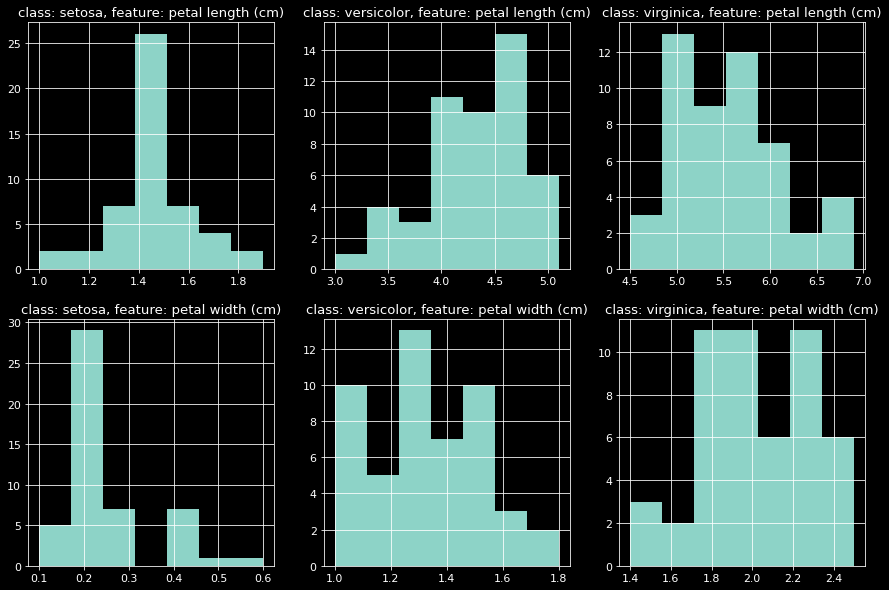

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        ax.hist(feature_col, bins=7)
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

We see, than the distributions within every class are unimodal. That's how KDE is approximating the PDF:

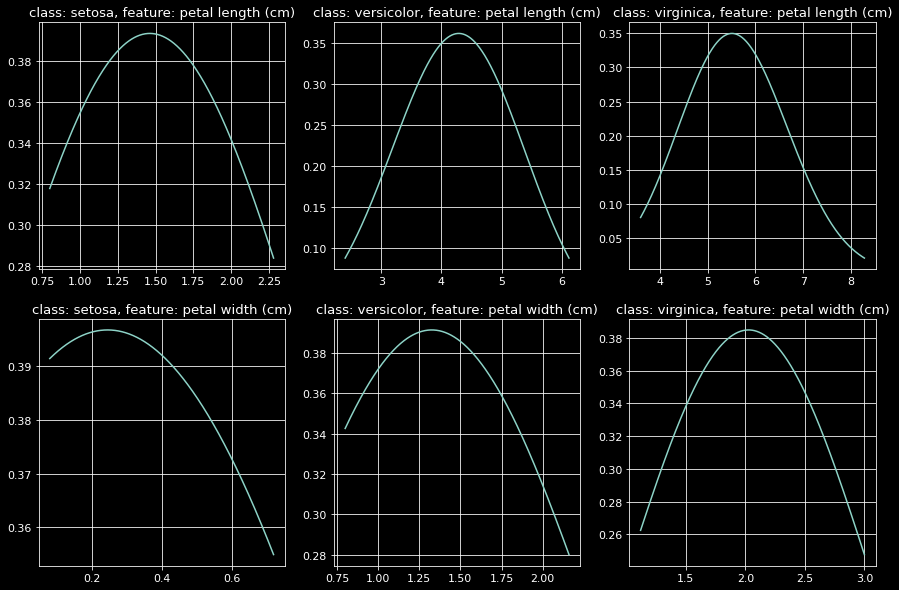

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
kde = KernelDensity(bandwidth=1., kernel='gaussian')

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        kde.fit(feature_col.reshape((-1, 1)))
        linspace = np.linspace(
            0.8*feature_col.min(),
            1.2*feature_col.max(),
            1000
        )
        ax.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

One could mention, that every feature need different `bandwidth` parameter.

And that's how Gaussian distribution fits to the data:

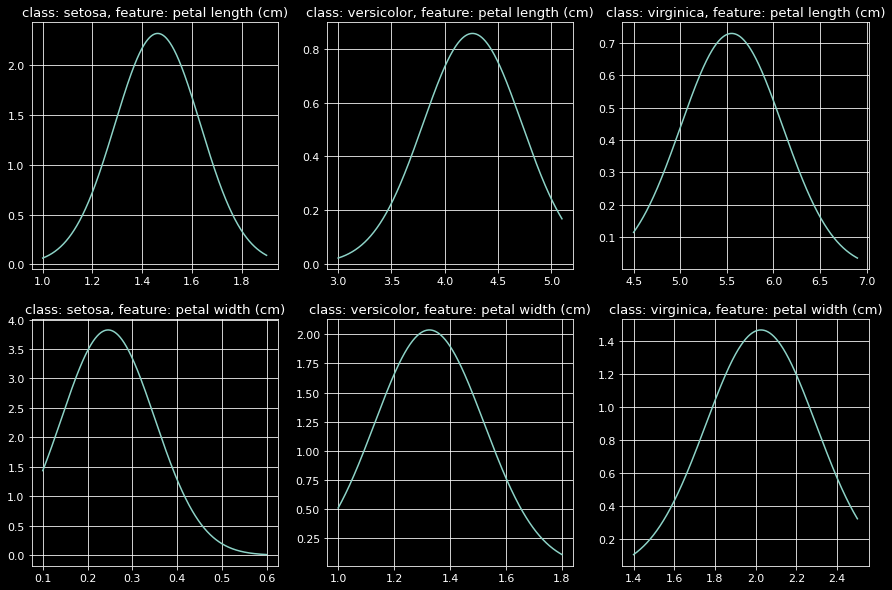

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        gaussian_distr = GaussianDistribution(feature_col)
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, gaussian_distr.pdf(linspace.reshape((-1, 1))))
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

Looks a bit better. Moreover, hypothesis of the normal distribution over the features seems more promising (the features are petal length and width).

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        ax.hist(feature_col, bins=7, density=True, alpha=0.4)
                
        bandwidth = abs((feature_col.min() - feature_col.max()) / 5)
        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kde.fit(feature_col.reshape((-1, 1)))
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))), c='m', label='KDE')
        
        gaussian_distr = GaussianDistribution(feature_col)
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, gaussian_distr.pdf(linspace.reshape((-1, 1))), c='g', label='Gaussian')        
        
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}
fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc="lower center",
  bbox_to_anchor=(0.5, 0),
  bbox_transform=plt.gcf().transFigure,
)

So, the __conclusion__: always check the distribution and the assumptions you make. They should be appropriate for the data you work with.